**Table of contents**<a id='toc0_'></a>    
- [<b>Load Dataset</b>](#toc1_)    
    - [Load Config Data](#toc1_1_1_)    
    - [Load Dataset](#toc1_1_2_)    
- [<b> Exploratory Data Analysis</b>](#toc2_)    
  - [Profile Report](#toc2_1_)    
  - [Describe Data](#toc2_2_)    
  - [<b> Histogram</b>](#toc2_3_)    
  - [<b>Kernel Density Plot</b>](#toc2_4_)    
  - [<b>Boxplot of Numeric features</b>](#toc2_5_)    
  - [<b>Segment Categorical features by the target classes</b>](#toc2_6_)    
  - [<b>Group numeric features by categorical features</b>](#toc2_8_)    


<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
## Load Configuration File

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import src.util as util
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from xgboost import XGBClassifier
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import klib
from ydata_profiling import ProfileReport, compare

In [3]:
sns.set_style('darkgrid')
sns.set(rc = {'axes.facecolor': '#FBFBFB', 'figure.facecolor': '#FBFBFB'})

class clr:
    start = '\033[93m'+'\033[1m'
    bold = '\033[1m'
    underline = '\033[4m'
    color = '\033[93m'
    end = '\033[0m'

# <a id='toc1_'></a>[<b>Load Dataset</b>](#toc0_)

In [4]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    # Load set of data
    x_train = util.pickle_load(config_data["train_set_path"][0])
    y_train = util.pickle_load(config_data["train_set_path"][1])

    x_valid = util.pickle_load(config_data["valid_set_path"][0])
    y_valid = util.pickle_load(config_data["valid_set_path"][1])

    x_test = util.pickle_load(config_data["test_set_path"][0])
    y_test = util.pickle_load(config_data["test_set_path"][1])

    # concatenate x and y each set
    train_set = pd.concat([x_train, y_train], axis = 1)
    valid_set = pd.concat([x_valid, y_valid], axis = 1)
    test_set = pd.concat([x_test, y_test], axis = 1)

    # return 3 set of data
    return train_set, valid_set, test_set

In [5]:
config_data = util.load_config()

In [6]:
train_set, valid_set, test_set = load_dataset(config_data)

# <a id='toc2_'></a>[<b> Exploratory Data Analysis</b>](#toc0_)

-----

## <a id='toc2_1_'></a>[Profile Report](#toc0_)

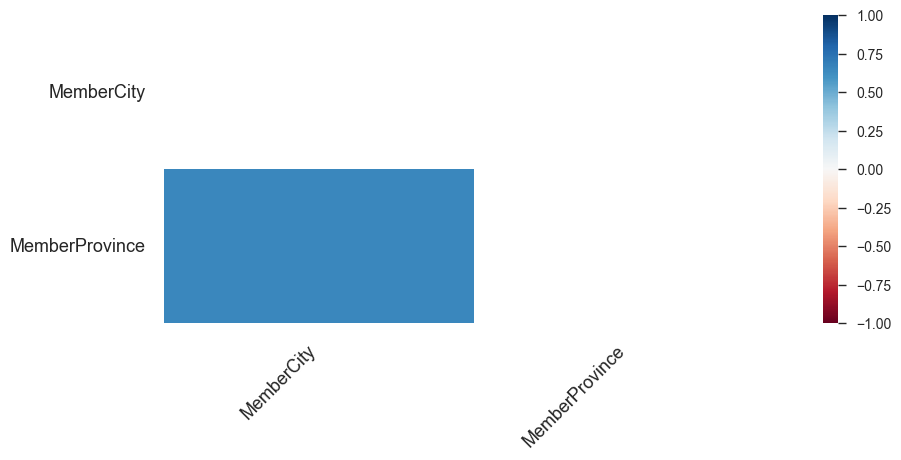

In [7]:
train_set_report = ProfileReport(train_set, progress_bar=False, title="train_set", explorative=True, sample=None)

train_set_report.to_file("data_profile_report.html")

## <a id='toc2_2_'></a>[Describe Data](#toc0_)

In [8]:
train_set.describe().style.background_gradient(cmap='YlOrBr')

,ReceivedDate,MemberIDscrambled,ClaimantAge,FacilityIDscrambled,PaymentIssueDate,ServiceDate
count,86201,86201.000000,86201.000000,86201.000000,86201,86201
mean,2023-03-07 11:04:45.866753536,32985.794480,59.574402,3244.207387,2023-03-07 06:46:34.185681920,2023-03-03 12:11:22.070973696
min,2023-03-01 00:00:00,1.000000,0.000000,1.000000,2022-10-05 00:00:00,2020-06-03 00:00:00
25%,2023-03-02 00:00:00,14103.000000,51.000000,1139.000000,2023-03-02 00:00:00,2023-03-02 00:00:00
50%,2023-03-04 00:00:00,33502.000000,61.000000,2799.000000,2023-03-05 00:00:00,2023-03-04 00:00:00
75%,2023-03-13 00:00:00,50999.000000,71.000000,4863.000000,2023-03-13 00:00:00,2023-03-12 00:00:00
max,2023-03-23 00:00:00,70166.000000,109.000000,9764.000000,2023-03-23 00:00:00,2023-03-23 00:00:00
std,nan,20990.614587,15.948563,2452.861484,nan,nan


In [9]:
train_set.describe(include='object')

,ClaimSubmissionChannel,ClaimantGender,MemberCity,MemberProvince,DINLevel1ClassCode,SubmittedAmount
count,86201,86201,86092,86151,86201,86201
unique,5,3,7062,19,4,18393
top,Pay Direct Drug,M,OTTAWA,ONT,D,$0.00
freq,82296,47804,2973,38309,45308,1884


In [10]:
# Create a function for pre-processing a dataframe
def preprocess(dfr):
    
    dfr[['ReceivedDate','PaymentIssueDate', 'ServiceDate']] = dfr[['ReceivedDate','PaymentIssueDate', 'ServiceDate']].apply(pd.to_datetime, format="%m/%d/%Y", errors="coerce")
 # Convert the dates to datetime format

    
    #submitted amout columns

    dfr['SubmittedAmountNumeric'] = dfr['SubmittedAmount'].str.replace('$', '').str.replace(',', '').astype(float)
    dfr['SubmittedAmountNumeric'] = dfr['SubmittedAmount'].str.replace('[\$,()]', '', regex=True).astype(float)
    dfr['SubmittedAmountNumeric'] = pd.to_numeric(dfr['SubmittedAmount'], errors='coerce').fillna(0)


    # submitted_amount_str = dfr['SubmittedAmount'].astype(str)
    # submitted_amount_numeric = pd.to_numeric(submitted_amount_str.str.replace('[\$,()]', ''), errors='coerce')
    # submitted_amount_numeric.fillna(0, inplace=True)
    # dfr['SubmittedAmountNumeric'] = submitted_amount_numeric

    #new columns
    # Create new features from date format columns
    dfr['ReceivedYear'] = dfr['ReceivedDate'].dt.year
    dfr['ReceivedMonth'] = dfr['ReceivedDate'].dt.month
    dfr['ReceivedDayOfWeek'] = dfr['ReceivedDate'].dt.dayofweek
    dfr['PaymentYear'] = dfr['PaymentIssueDate'].dt.year
    dfr['PaymentMonth'] = dfr['PaymentIssueDate'].dt.month
    dfr['PaymentDayOfWeek'] = dfr['PaymentIssueDate'].dt.dayofweek
    dfr['ServiceYear'] = dfr['ServiceDate'].dt.year 
    dfr['ServiceMonth'] = dfr['ServiceDate'].dt.month
    dfr['ServiceDayOfWeek'] = dfr['ServiceDate'].dt.dayofweek

    # Calculate 'member_claims_count' and 'member_avg_amount'
    dfr['member_claims_count'] = dfr.groupby('MemberCity')['SubmittedAmountNumeric'].transform('count')
    dfr['member_avg_amount'] = dfr.groupby('MemberCity')['SubmittedAmountNumeric'].transform('mean')

    # Calculate 'member_claims_count' and 'member_avg_amount'
    dfr['member_claims_count_by_province'] = dfr.groupby('MemberProvince')['SubmittedAmountNumeric'].transform('count')
    dfr['member_avg_amount_by_province'] = dfr.groupby('MemberProvince')['SubmittedAmountNumeric'].transform('mean')

    # Create new features that represent the ratio of 'SubmittedAmount' to 'member_claims_count'
    dfr['AmountToClaimsCountRatio'] = dfr['SubmittedAmountNumeric'] / dfr['member_claims_count']
    
    subset = dfr[['DINLevel1ClassCode','ClaimSubmissionChannel','ClaimantGender','MemberProvince']] # Create a subset of relevant categorical columns
   #  feature_arr = ohe.transform(subset).toarray() # Transform the dataframe using one-hot encoding
   #  feature_labels = ohe.get_feature_names_out() # Extract the encoded feature labels

   #  features = pd.DataFrame(feature_arr, columns=feature_labels, index=subset.index) # Create a dataframe for feature array & labels post-encoding


   #  dfr = pd.concat([dfr,features], axis=1) # Concat the (now) feature dataframe with the argument dataframe

   #  drop_columns = ['DINLevel1ClassCode','ExpenseType','ClaimSubmissionChannel', 'ClaimantAge', 'ClaimantGender', \
   #                 'MemberProvince', 'SubmittedAmount', ]

   #  dfr = dfr.drop(columns= drop_columns) # Drop redundant columns
    
    return dfr # Return the pre-processed dataframe

In [11]:
# Encode and pre-process the train set
'MemberProvince_nan'
X_train = preprocess(train_set)
X_train.head()

,ReceivedDate,MemberIDscrambled,ClaimSubmissionChannel,ClaimantAge,ClaimantGender,FacilityIDscrambled,MemberCity,MemberProvince,PaymentIssueDate,ServiceDate,...,PaymentMonth,PaymentDayOfWeek,ServiceYear,ServiceMonth,ServiceDayOfWeek,member_claims_count,member_avg_amount,member_claims_count_by_province,member_avg_amount_by_province,AmountToClaimsCountRatio
49192,2023-03-04,53509,Pay Direct Drug,80,M,9148,Calgary,ALTA,2023-03-04,2023-03-04,...,3,5,2023,3,5,836.0,0.0,9153.0,0.0,0.0
32155,2023-03-03,39932,Pay Direct Drug,65,F,5723,PRINCEVILLE,QUE,2023-03-03,2023-03-03,...,3,4,2023,3,4,4.0,0.0,18226.0,0.0,0.0
7505,2023-03-01,53498,Pay Direct Drug,72,M,6931,COALDALE,ALTA,2023-03-01,2023-03-01,...,3,2,2023,3,2,8.0,0.0,9153.0,0.0,0.0
55334,2023-03-05,42539,Pay Direct Drug,59,F,5435,BATTERSEA,ONT,2023-03-05,2023-03-05,...,3,6,2023,3,6,8.0,0.0,38309.0,0.0,0.0
25146,2023-03-02,54749,Pay Direct Drug,64,F,2358,SHERWOOD PARK,ALTA,2023-03-02,2023-03-02,...,3,3,2023,3,3,171.0,0.0,9153.0,0.0,0.0


## <a id='toc2_3_'></a>[<b> 1. Histogram</b>](#toc0_)

What we look out for:
- Potential <b>outliers</b>
- <b>Numeric features that should be categorical (indicator)</b> features. For example, if there are only two possible values like 0 and 1.
- Boundaries that do not make sense, such as <b>percentage value more than 100</b>.

Using the `histplot` from seaborn with `kind = kde`, and separate the histogram into two category of target. <br>
Histogram are using to approach the miscellaneous thing we seek before, while `kde` are using to understand the distribution of the numeric features.

<Figure size 1000x1000 with 0 Axes>

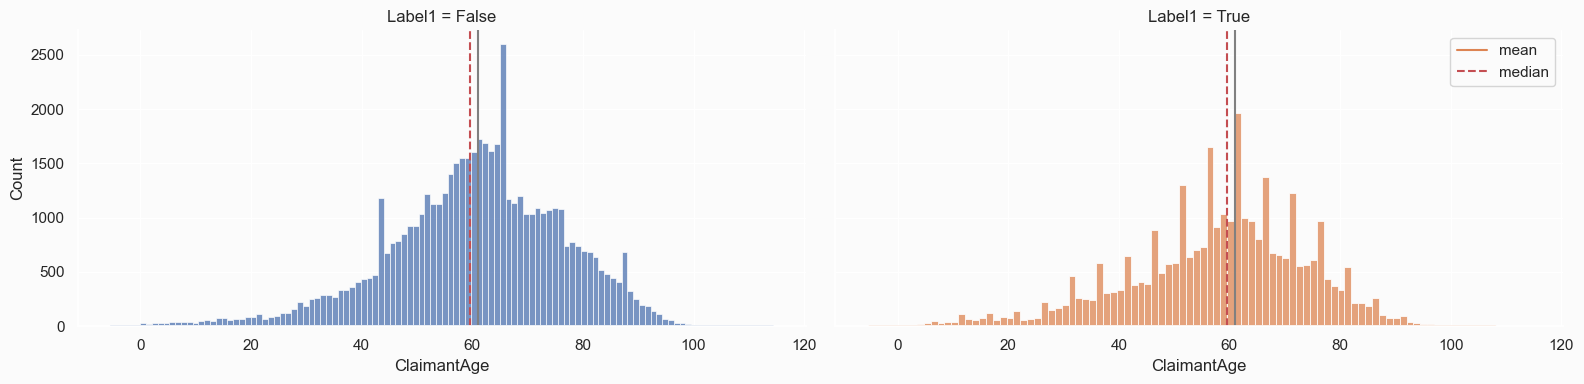

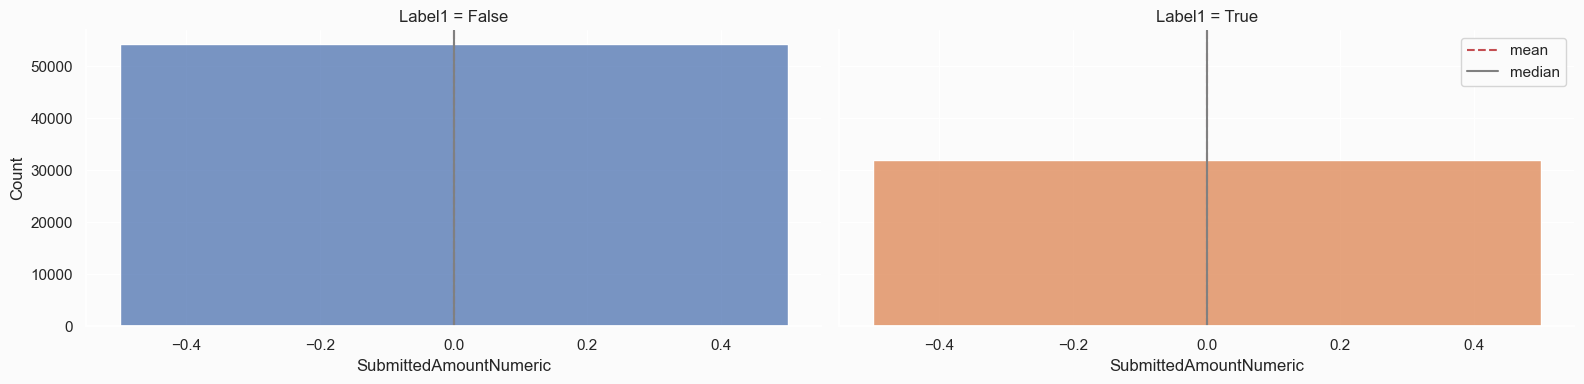

In [12]:
list_num_col = ['ClaimantAge', 'SubmittedAmountNumeric']

# for col in train_set.columns:
#     if (train_set[col].dtype =='int32'):
#         list_num_col.append(col)

plt.figure(figsize=(10,10))
count = 0

for i in range(len(list_num_col) // 2):
    for j in range(2):

        if count >= len(list_num_col):
            break

        g = sns.FacetGrid(data=train_set, col='Label1', hue='Label1', height=4, aspect= 2)
        g.map_dataframe(sns.histplot, x=list_num_col[count])
        g.map_dataframe(sns.kdeplot, x=list_num_col[count])
        
        g.refline(x=train_set[list_num_col[count]].mean(), color='r')
        g.refline(x=train_set[list_num_col[count]].median(), linestyle='-')

        plt.legend(['mean', 'median'])

        count += 1

plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

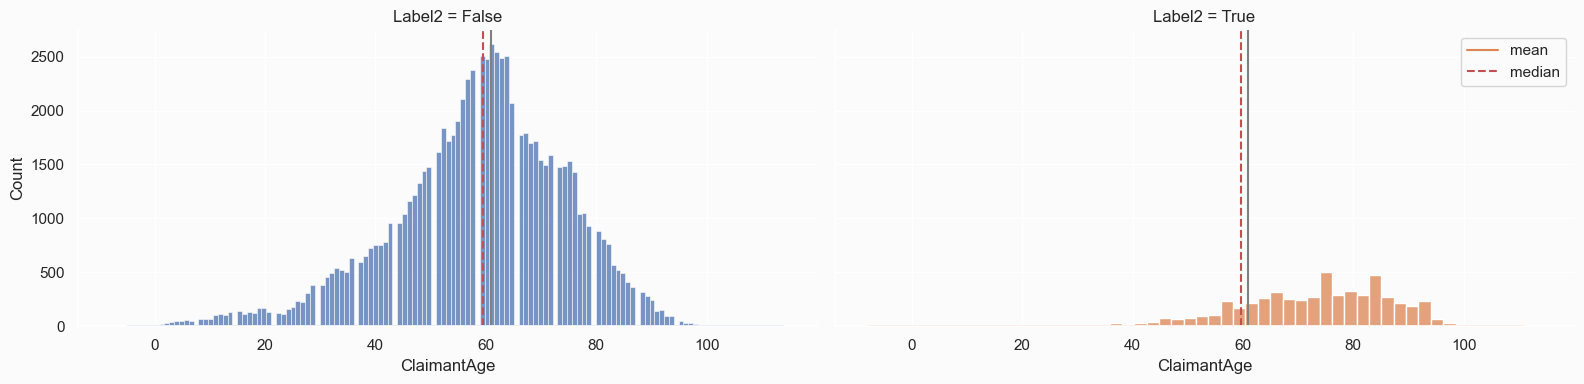

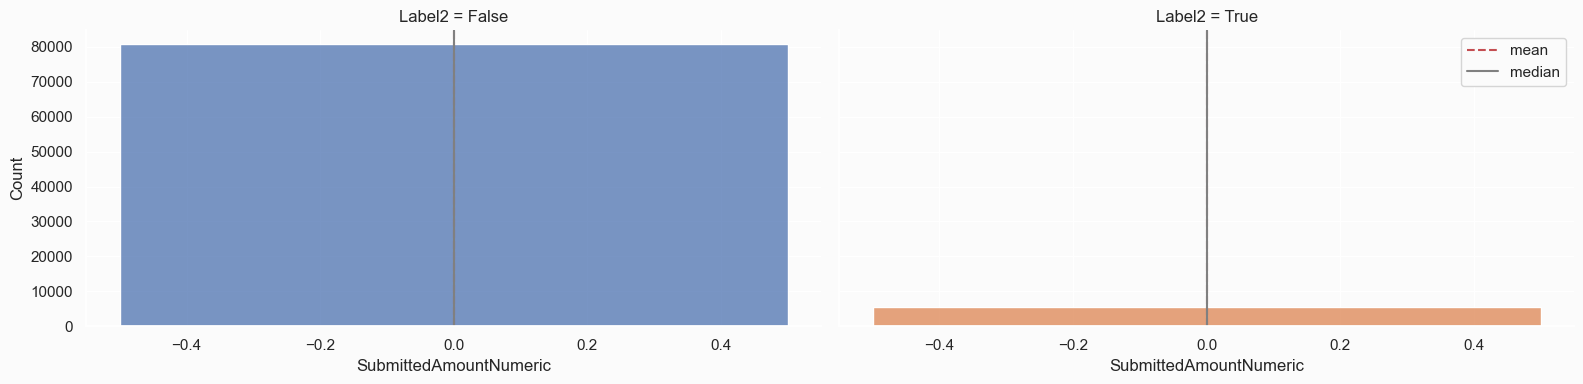

In [13]:
list_num_col = ['ClaimantAge', 'SubmittedAmountNumeric']

# for col in train_set.columns:
#     if (train_set[col].dtype =='int32'):
#         list_num_col.append(col)

plt.figure(figsize=(10,10))
count = 0

for i in range(len(list_num_col) // 2):
    for j in range(2):

        if count >= len(list_num_col):
            break

        g = sns.FacetGrid(data=train_set, col='Label2', hue='Label2', height=4, aspect= 2)
        g.map_dataframe(sns.histplot, x=list_num_col[count])
        g.map_dataframe(sns.kdeplot, x=list_num_col[count])
        
        g.refline(x=train_set[list_num_col[count]].mean(), color='r')
        g.refline(x=train_set[list_num_col[count]].median(), linestyle='-')

        plt.legend(['mean', 'median'])

        count += 1

plt.tight_layout()
plt.show()


- <b>`SubmittedAmountNumeric`</b> is highly <b>right-skewed</b> distributed and should be dealt with a Log-Transformation

## <a id='toc2_4_'></a>[<b>2. Kernel Density Plot</b>](#toc0_)

KDE plot using `klib.dist_plot` to give better distribution comprehension of numeric features, given <b>mean, median, and standard deviation</b>

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='MemberIDscrambled', ylabel='Density'>

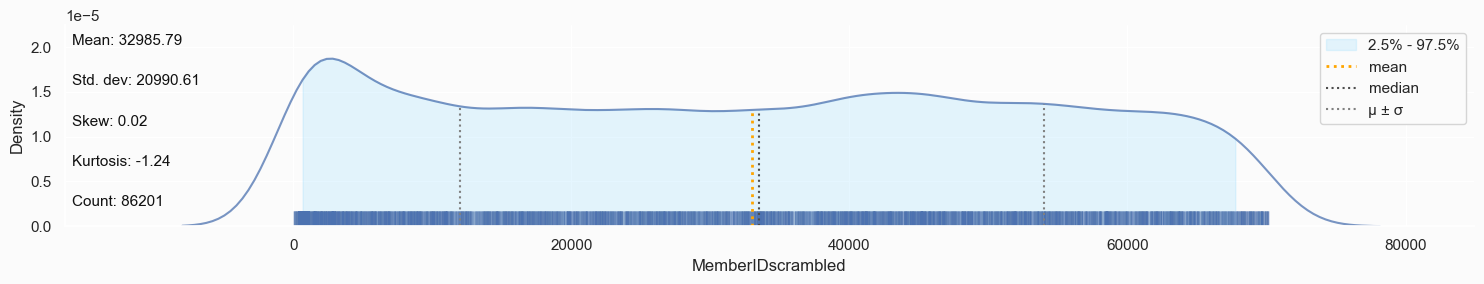

In [14]:
klib.dist_plot(train_set)

## <a id='toc2_5_'></a>[<b>3. Boxplot of Numeric features</b>](#toc0_)

**Segment the target by numeric features**

<center>
<img src='https://th.bing.com/th/id/OIP.0MPDTLn8KoLApoFvI0P2vQHaDt?pid=ImgDet&rs=1'>
</center>

We will use **`sns.boxplot`** which displays the five-number summary of a numeric feature. The five numbers are **minimum**, **first quartile (Q1 or 25% mark)**,**median (Q2)**, **third quartile (Q3 or 75% mark)**, and **maximum**

Here, we will separate the data by the target feature and observe how the numeric features are distributed among those which **fraud (target = 1)** and those which **non-fraud (target = 0)**.



In [15]:
# function to create histogram, Q-Q plot and
# boxplot. We learned this in section 3 of the course
import matplotlib.pyplot as plt
import seaborn as sns
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

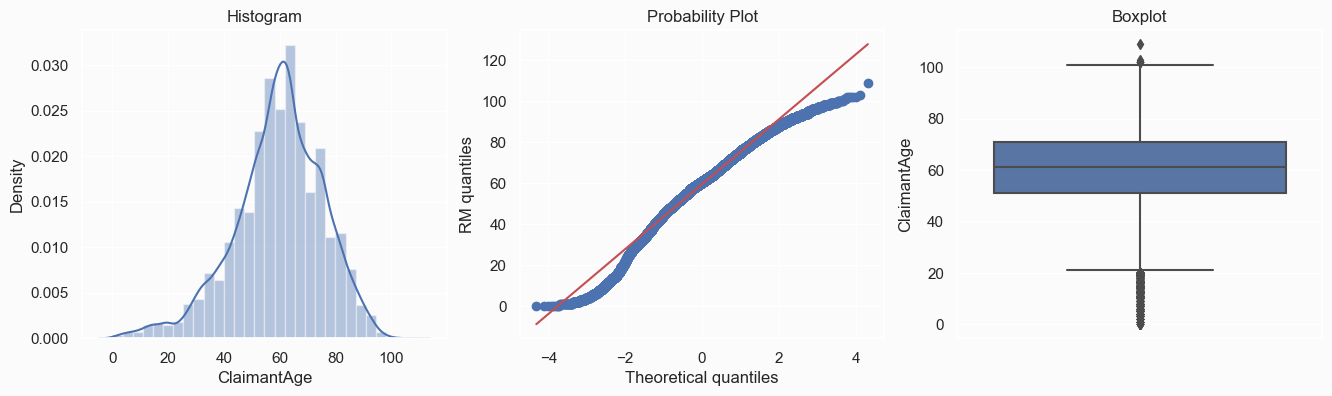

In [16]:
diagnostic_plots(train_set, 'ClaimantAge')

- Histogram Observations: Upon examining the histograms, we observe that the 'ClaimantAge' feature exhibits a normal distribution, indicating a symmetrical spread of claimant ages around the mean. In contrast, the 'SubmittedAmount' feature shows a right-skewed distribution, suggesting that while most claims are of lower value, there are a significant number of higher value claims as well. This skewness is indicative of outliers or extreme values in the claim amounts.

- Box Plot Observations: The box plots reveal that the 'ClaimantAge' feature has a median around 60 years, with a fairly even spread as indicated by the IQR. However, the 'SubmittedAmount' feature's box plot shows a median significantly lower than the mean, due to the right-skewed distribution observed in the histogram. The whiskers extend far beyond the upper quartile, highlighting the presence of outliers in the claim amounts.